In [89]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import load_img
import glob
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy
import keras
from keras.models import load_model


# Introduction
Semantic segmentation is the classification of every pixel in an image. In this notebook, a U-net style model is trained to segment images of dancers from TikTok. The data is available [here](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-tiktok-dancing-dataset).

A trained version of the model is available on my google drive, [here](https://drive.google.com/file/d/1exu05AxcL2OGrtcZIMrllR1ogUXHbNe9/view?usp=sharing).

# Loading Data

In [90]:
img_dir = 'images/'
mask_dir = 'masks/'

In [91]:
image_files = glob.glob(img_dir+'*')
mask_files = glob.glob(mask_dir+'*')

In [92]:
images = []
masks = []
target_size = (128,128)
for i, img_file in enumerate(image_files):
    img = load_img(img_file, color_mode='rgb', target_size=target_size)
    images.append(img)
    
    mask = load_img(mask_files[i], color_mode='grayscale', target_size=target_size)
    masks.append(mask)

Below two examples are shown, each an image with its mask overlaid.

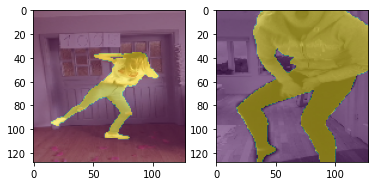

In [93]:
test_idx=1
fig, axes = plt.subplots(1,2)
axes[0].imshow(images[test_idx])
axes[0].imshow(masks[test_idx], alpha=0.5)


axes[1].imshow(images[test_idx+10])
axes[1].imshow(masks[test_idx+10], alpha=0.5)
plt.show()

# Split Data
The data is split into training and test sets.

In [94]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, shuffle=True, random_state=123)

# Augmentation
Since the data set is fairly small, some data augmentation is performed. This is limited to arbitrary rotations and small translations.

In [95]:
def rotate_image(img, mask):
    '''
    Rotates an image and associated mask by a random angle
    '''
    angle = np.random.uniform(-180,180)
    img = img.rotate(angle)
    mask = mask.rotate(angle)
    return img, mask

def translate_image(img, mask):
    '''
    Translates an image and associated mask randomly by up to 10 pixels in any direction
    Affine matrix transforms (x, y) --> (ax+by+c, dx+ey+f)
    '''
    a, b, d, e = 1, 0, 0, 1
    c = np.random.uniform(-10,10)
    f = np.random.uniform(-10,10)
    img = img.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    mask = mask.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    return img, mask

def augmentation(images, masks):
    trans_count = 0
    rot_count = 0
    print(len(images))
    augmented_images, augmented_masks = images.copy(), masks.copy()
    for i, img in enumerate(images):
        # Note some *small* probability of these both being true and still no augmentation
        rotate = bool(np.round(np.random.uniform(0,1)))
        translate = bool(np.round(np.random.uniform(0,1)))
        
        mask = masks[i]
        if rotate:
            img, mask = rotate_image(img, mask)
            rot_count += 1
        if translate:
            img, mask = translate_image(img, mask)
            trans_count += 1
        if translate or rotate:
            augmented_images.append(img)
            augmented_masks.append(mask)
    
    print(f'Rotated {rot_count} images')
    print(f'Translated {trans_count} images')
    return augmented_images, augmented_masks

aug_rounds = 2
for round in range(aug_rounds):
    x_train, y_train = augmentation(x_train, y_train)

2353
Rotated 1201 images
Translated 1166 images
4127
Rotated 2035 images
Translated 2110 images


# Convert Images to Numpy Arrays

First, I check the values in the masks.

In [96]:
np.unique([np.asarray(mask) for mask in masks])

array([  0, 255], dtype=uint8)

The "positive" values in the mask are 255. But since the model will be trained using cross entropy, this is very undesirable. Rather, we want the values in the mask to be either 0 or 1. So all of the values in the masks are divided by 255. Similarly, the images are normalized using the same operation.

In [97]:
def data_to_numpy(images, masks):
    images = [np.asarray(img) for img in images]
    masks = [np.asarray(mask) for mask in masks]
    
    return np.asarray(images)/255, np.asarray(masks)/255 

x_train, y_train = data_to_numpy(x_train, y_train)
x_test, y_test = data_to_numpy(x_test, y_test)

# Baseline
To get benchmark against which to compare my model, I compute the pixel wise accuracy in the case which every pixel is predicted to be the background. This is analogous to - if not exactly the same as - comparing the performance of a classifier on an unbalanced dataset against one that always predicts the majority class.

In [98]:
all_background = np.zeros_like(y_test)
m = Accuracy()
m.update_state(y_true=y_test, y_pred=all_background)
acc = m.result().numpy()
print(f'Accuracy when always predicting background', acc)

Accuracy when always predicting background 0.9059984


We can see from the above that the most naive solution to the segmentation task - assuming every pixel belongs to the majority class, will result in an accuracy of 90%. The bare minimum is to beat that.

# Build Model
The model used is essentially U-Net. There is a downscaling portion of the model and an upscaling portion. The downscaling portions consists of convolutional layers followed by maxpooling layers which half the size of the image in each direction. The upscaling portion does the reverse: transposed convolutions upscale the image and more convolutional layers extract features as the image is upscaled. Once the upscaling is complete, the model is passed through a dense layer. To pass information through the network and preserve gradients, skip connections are used. In the downscaling part of the network, before maxpooling, the feature maps are saved. These are then concatenated with feature map outputs of the appropriate shape during upscaling.

An alternative model downscales the image by increasing the stride of the convolutional layer. I found no substantial difference in performance between eiher model architecture.

The model output gives the probability that each pixel contains a person. The model is evaluated using pixel-wise accuracy, the percentage of pixels that are correctly classified.

In [13]:
def get_model_w_pooling(img_shape):
    inputs = keras.Input(shape=img_shape)
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs) 
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(64, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(128, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(256, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(512, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(1024, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(1024, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(512, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) 
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Second upconv layer
    x = layers.Conv2DTranspose(256, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(128, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(64, kernel_size=(2), strides=(2), kernel_initializer='he_normal')(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    outputs = layers.Conv2D(1, kernel_size=(1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model_w_pooling(x_train[0].shape) # 1 + sigmoid b/c binary
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics='accuracy')
# metrics=CustomMeanIoU(num_classes=len(df)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
es = EarlyStopping(min_delta=0.001, patience=15,restore_best_weights=True)
history = model.fit(x_train, np.expand_dims(y_train, axis=-1), validation_split=0.1, epochs=300, callbacks=[es], batch_size=16)

Epoch 1/300
405/405 [==============================] - 70s 156ms/step - loss: 0.2300 - accuracy: 0.9106 - val_loss: 0.1971 - val_accuracy: 0.9152
Epoch 2/300
405/405 [==============================] - 57s 142ms/step - loss: 0.1419 - accuracy: 0.9416 - val_loss: 0.1453 - val_accuracy: 0.9389
Epoch 3/300
405/405 [==============================] - 58s 143ms/step - loss: 0.1118 - accuracy: 0.9540 - val_loss: 0.1351 - val_accuracy: 0.9415
Epoch 4/300
405/405 [==============================] - 57s 142ms/step - loss: 0.0964 - accuracy: 0.9606 - val_loss: 0.1513 - val_accuracy: 0.9425
Epoch 5/300
405/405 [==============================] - 58s 143ms/step - loss: 0.0821 - accuracy: 0.9664 - val_loss: 0.1240 - val_accuracy: 0.9517
Epoch 6/300
405/405 [==============================] - 58s 142ms/step - loss: 0.0714 - accuracy: 0.9711 - val_loss: 0.0907 - val_accuracy: 0.9629
Epoch 7/300
405/405 [==============================] - 57s 142ms/step - loss: 0.0636 - accuracy: 0.9744 - val_loss: 0.1107 -

In [ ]:
model.save('trained_model')

# Evaluation
I evaluatte the model by looking at its accuracy. I also show some random examples of model outputs.

In [99]:
model = load_model('trained_model')

In [100]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

9/9 [==============================] - 3s 181ms/step


In [101]:
m = Accuracy()
m.update_state(y_true=y_test, y_pred=y_pred)
acc = m.result().numpy()
print(f'Accuracy of on test set', acc)

Accuracy of on test set 0.99000376


We have an accuracy of 99%. This is an improvement over the baseline.

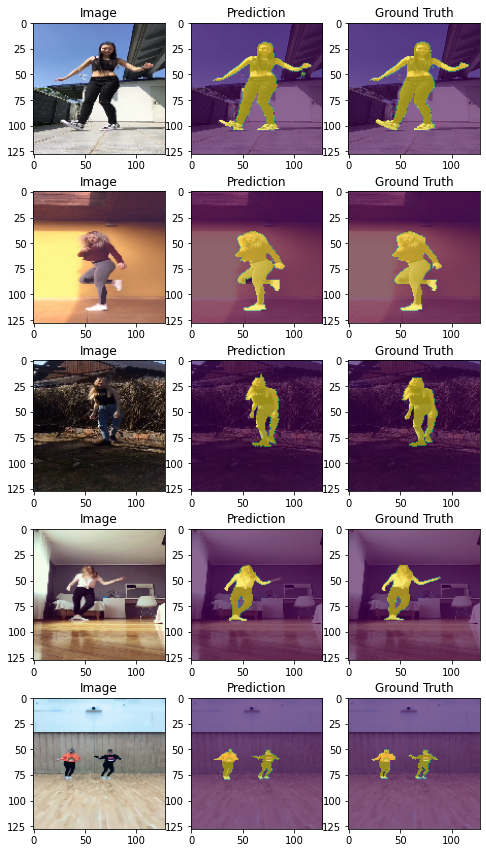

In [102]:
num_examples = 5
fig, axes = plt.subplots(num_examples,3, figsize=(8,15))

for i in range(num_examples):
    test_idx=np.random.randint(0, len(x_test))
    ## Raw image
    axes[i][0].imshow(x_test[test_idx])
    axes[i][0].set_title('Image')
    
    # Predictions
    axes[i][1].imshow(x_test[test_idx])
    axes[i][1].imshow(y_pred[test_idx], alpha=0.6)
    axes[i][1].set_title('Prediction')

    # Ground Truth
    axes[i][2].imshow(x_test[test_idx])
    axes[i][2].imshow(y_test[test_idx], alpha=0.6)
    axes[i][2].set_title('Ground Truth')

There are some imperfections in the examples, but the model performs well.

# Testing the model on screenshots
To test the model on even more unseen data, I took some screenshots from a TikTok dance compilation on youtube and ran them through the model.

In [103]:
def predict_image(img_path):
    '''
    Formats an input image and uses the formated image to predict a mask.
    '''
    img = load_img(img_path, color_mode='rgb', target_size=target_size)
    img = np.asarray(img)/255
    img = np.expand_dims(img, axis=0)
    mask = np.round(model.predict(img, verbose=0)[0])
    return mask, img[0]

def plot_image(mask, img):
    '''
    Plots an image with the mask overlaid and the image by itself
    '''
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(img)
    axes[0].set_title('Prediction')
    axes[0].imshow(mask, alpha=0.5)


    axes[1].imshow(img)
    axes[1].set_title('Image')
    plt.show()

First a test on a shot with a single person. This is mooyamusunga on TikTok.

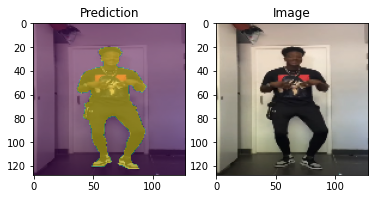

In [104]:
mask, img = predict_image('screenshot example.png')

plot_image(mask, img)

I note that the model was trained on videos containing only one person. I suspect it will have trouble if there are more people in the image. An example is below. These are from the accounts rylenbesler and kennilove03.

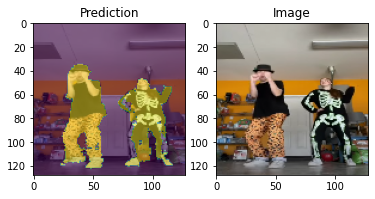

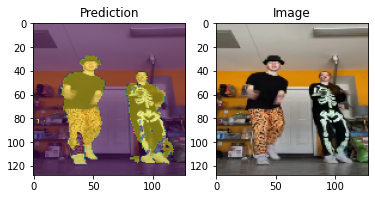

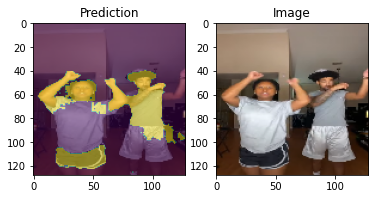

In [105]:
mask, img = predict_image('two_dancers.png')

plot_image(mask, img)

mask, img = predict_image('two_dancers2.png')

plot_image(mask, img)

mask, img = predict_image('two_dancers3.png')

plot_image(mask, img)

Noting that these are just three images, there still seems to be some obvious drop in performance. Given the model was not trained on such images, this is expected.

# Using the Model to Remove the Background from Images
An simple example application of a segmentation model is to remove the background from images. Note that this is easily extended to replacing the background on images.

In [106]:
example_image = np.expand_dims(x_test[100], axis=0)
pred_mask = model.predict(example_image)
pred_mask = np.round(pred_mask)

1/1 [==============================] - 0s 14ms/step


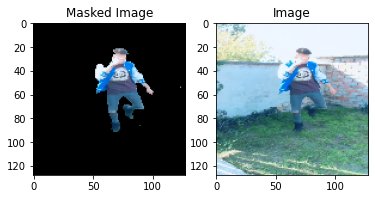

In [107]:
# Create 2D mask and stack so it has 3 channels
bool_mask = np.squeeze(np.where(pred_mask == 0, True, False))
bool_mask = np.stack([bool_mask for i in range(example_image.shape[-1])], axis=-1)

# Below is zero where masked, original value otherwise
masked_img = np.where(bool_mask, 0, np.squeeze(example_image))


fig, axes = plt.subplots(1,2)
axes[0].imshow(masked_img)
axes[0].set_title('Masked Image')

axes[1].imshow(np.squeeze(example_image))
axes[1].set_title('Image')

plt.show()

It is easy to see how this extends to replacing backgrounds or once extended to multiclass applications and instance segmenation, as part of a pipeline for removing objects from images.

# Conclusion

A model was trained to segment images of dancers. The model outperformed the baseline with an accuracy of 99%.